# Mixture Density Networks

A mixture density network is a probabilistic model of the form

$$
    p({\bf t}|{\bf x}) = \sum_{k=1}^K \pi_k({\bf x})\mathcal{N}({\bf t}, {\boldsymbol \mu}_k({\bf x}), {\bf I}\sigma_k^2)
$$

Where the coefficients in the model, namely $\{\pi_k({\bf x})\}_k$, $\{{\boldsymbol \mu}_k({\bf x})\}_k$, and $\{\sigma_k({\bf x})\}_k$ are modelled as the outputs of a feedforward neural nework.

A mixture density network is of use whenever we are presented with multimodal or nongauassian data

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed, normal, uniform, randn
from sklearn.neural_network import MLPRegressor

In [2]:
%config InlineBackend.figure_format = "retina"
np.set_printoptions(suppress=True, precision=3)

In [3]:
seed(2718)
nsamples = 100
xn = uniform(low=0, high=1, size=nsamples)
noise = uniform(low=-0.1, high=0.1, size=nsamples)
tn = xn + 0.3 * np.sin(2 * np.pi * xn) + noise

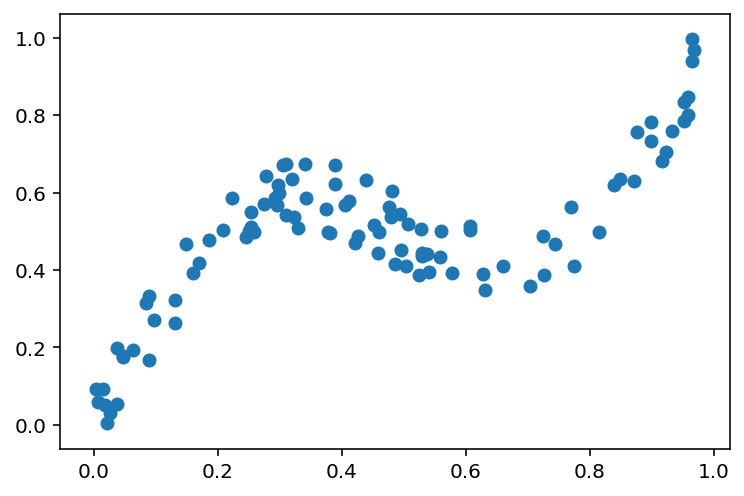

In [4]:
plt.scatter(xn, tn)

## The forward and inverse problems

In [5]:
xrange = np.linspace(0, 1, 100)

In [6]:
nn_forward = MLPRegressor(hidden_layer_sizes=(6, 6),
                  activation="tanh",
                  learning_rate_init=0.1,
                  solver="lbfgs", random_state=314)
nn_forward.fit(xn.reshape(-1, 1), tn)
yn_forward = nn_forward.predict(xrange.reshape(-1, 1))

In [7]:
nn_inverse = MLPRegressor(hidden_layer_sizes=(6, 6),
                  activation="tanh", 
                  learning_rate_init=0.1, tol=1e-6,
                  solver="lbfgs", random_state=3141)

nn_inverse.fit(tn.reshape(-1, 1), xn)
yn_inverse = nn_inverse.predict(xrange.reshape(-1, 1))

In [8]:
[c.shape for c in nn_forward.coefs_]

[(1, 6), (6, 6), (6, 1)]

In [9]:
[c.shape for c in nn_forward.intercepts_]

[(6,), (6,), (1,)]

In [10]:
print(f"Loss for the forward problem: {nn_forward.loss_:0.4f}")
print(f"Loss for the inverse problem: {nn_inverse.loss_:0.4f}")

Loss for the forward problem: 0.0017
Loss for the inverse problem: 0.0143


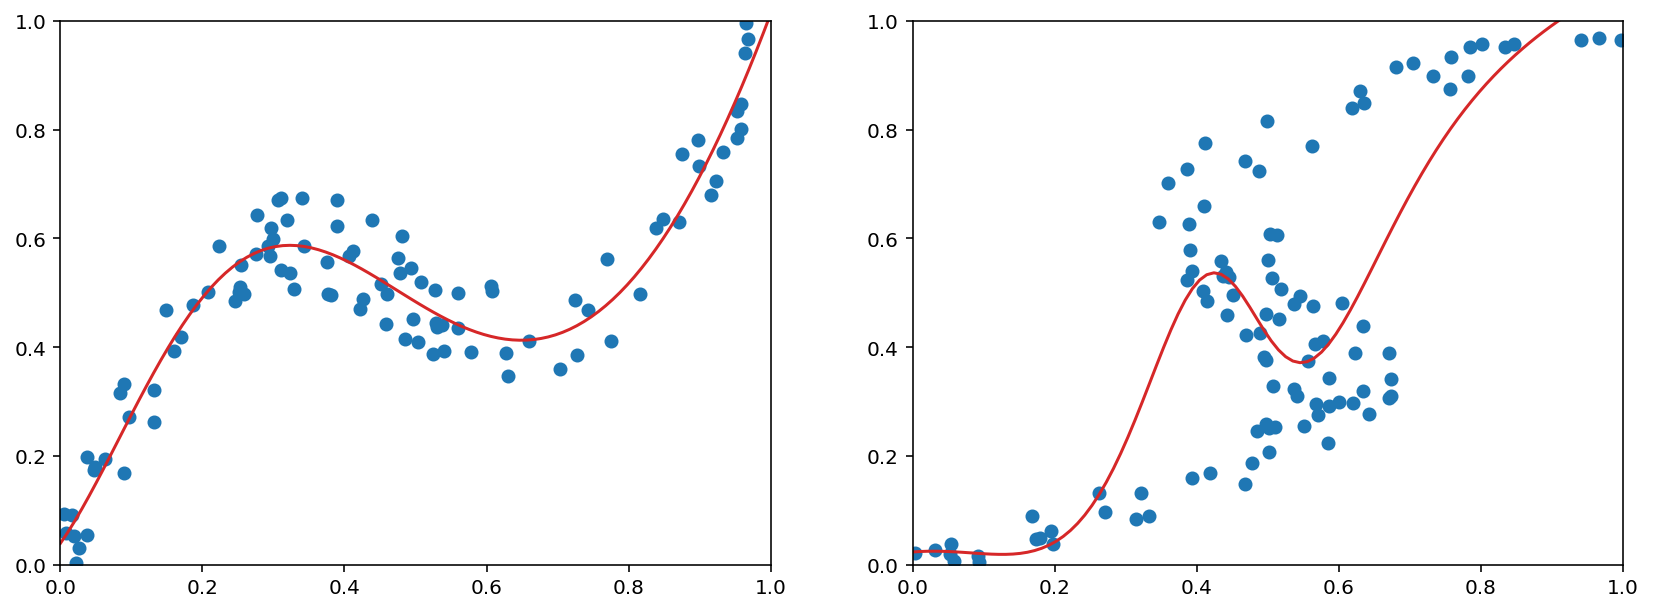

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].scatter(xn, tn)
ax[0].plot(xrange, yn_forward, c="tab:red")

ax[1].scatter(tn, xn)
ax[1].plot(xrange, yn_inverse, c="tab:red")

for axi in ax:
    axi.set_xlim(0, 1)
    axi.set_ylim(0, 1)

Choosing a least squares error function corresponds to a maximum likelihood under a Gaussian assumption. If the distribution of the parameters to fit is highly non-gaussian, the model cannot caputre the nature of the data.

## Model Retraining

Before training the mixture density network, we begin by re-training the network using numpy and scipy so that we may debug and train the mixture using central diferences and L-BFGS

In [13]:
from scipy.optimize import minimize

In [14]:
seed(314)
w = normal(size=1 * 6 + 6 * 6 + 6 * 1 + 6 + 6 + 1)
w = np.clip(w, -1, 1)

In [15]:
def fforward(W, X):
    """
    A two-layered feed-forward activation function with "n" units
    at each hidden layer; one input unit; and one output unit
    """
    # weights
    w1 = W[:6].reshape(1, 6)
    w2 = W[6: 36 + 6].reshape(6, 6)
    w3 = W[42: 42 + 6].reshape(6, 1)
    # Biases
    wb1 = W[48:48 + 6]
    wb2 = W[54: 54 + 6]
    wb3 = W[60:]

    return np.tanh(np.tanh(X @ w1 + wb1) @ w2 + wb2) @ w3 + wb3

def nntrain(w, X, y):
    t = fforward(w, X).ravel()
    err2 = np.mean((t - y) ** 2) 
    return err2

### Central Differences Approximation

In [16]:
X = xn.reshape(-1, 1)

In [17]:
%%time
w0 = w.copy()
eps = 0.01
alpha = 0.7
epochs = 700
perturb = np.identity(w0.shape[0]) * eps

E_hist = []
for e in range(epochs):
    for ix, p in enumerate(perturb):
        w0[ix] = w0[ix] - alpha * (nntrain(w0 + p, X, tn) - nntrain(w0 - p, X, tn)) / (2 * eps)
    E_epoch = nntrain(w0, X, tn)
    E_hist.append(E_epoch)

CPU times: user 3.55 s, sys: 11.8 ms, total: 3.56 s
Wall time: 3.58 s


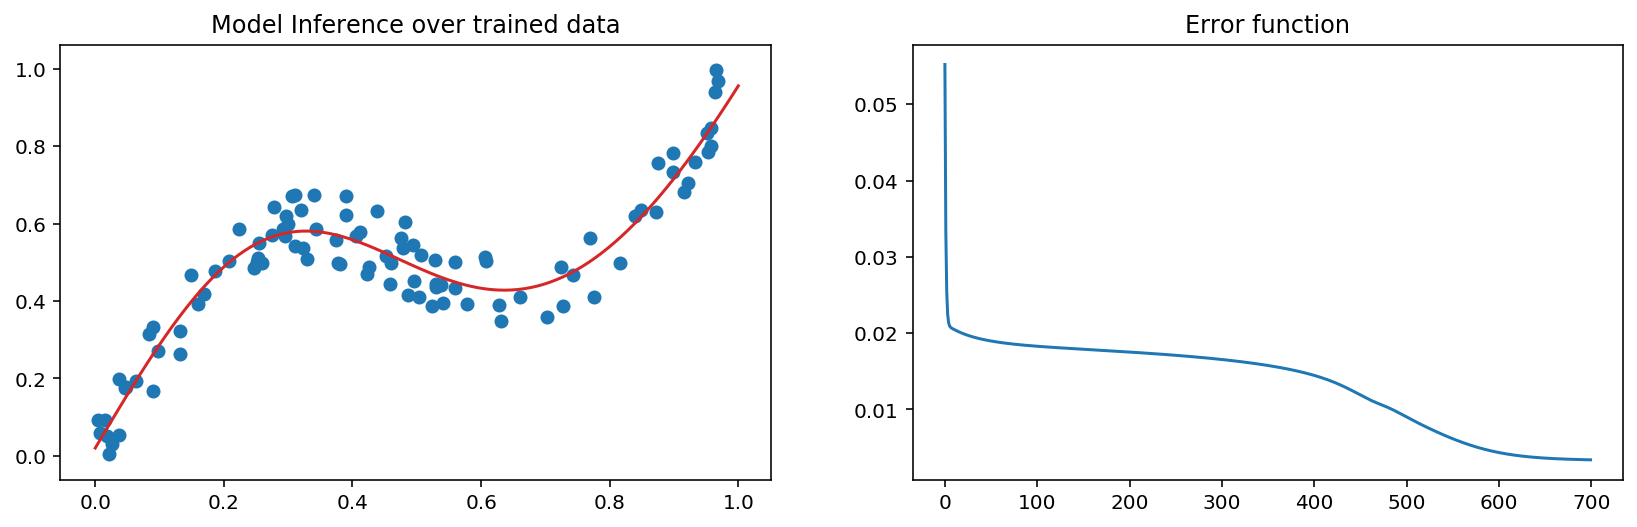

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].scatter(X, tn)
ax[0].plot(xrange, fforward(w0, xrange.reshape(-1, 1)), c="tab:red")
ax[1].plot(E_hist)
ax[0].set_title("Model Inference over trained data")
ax[1].set_title("Error function");

### With L-BFGS

In [19]:
%%time
nnw = minimize(nntrain, w, (X, tn), method="l-bfgs-b",
               tol=1e-20)
nnw

CPU times: user 751 ms, sys: 4.37 ms, total: 755 ms
Wall time: 758 ms


      fun: 0.00327825121316806
 hess_inv: <61x61 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0.,  0., -0., -0.,
        0.,  0., -0., -0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
        0., -0., -0.,  0., -0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0.,
        0.,  0., -0., -0., -0., -0.,  0.,  0., -0., -0.,  0., -0., -0.,
        0., -0.,  0., -0., -0.,  0.,  0., -0.,  0.])
  message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
     nfev: 15004
      nit: 182
   status: 1
  success: False
        x: array([-1.468, -2.49 , -0.507,  0.14 , -3.518, -2.171,  2.37 ,  0.478,
       -0.447,  1.845, -0.23 , -0.85 , -0.589,  0.873,  1.682, -2.079,
       -0.374,  0.872,  1.265,  0.982,  0.289, -1.646, -0.558,  0.835,
       -0.078,  0.386,  1.882, -1.129, -0.631, -1.011, -1.638, -0.836,
       -1.076, -1.609, -2.142,  1.272, -1.879, -0.094, -1.293,  0.564,
        0.172,  0.291,  1.147, -0.016,  0.472,  0.93 ,  0.626,  

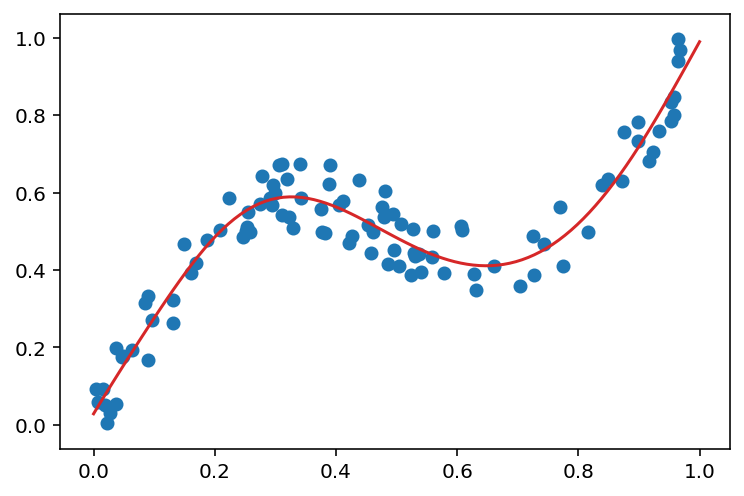

In [20]:
w0 = nnw.x
plt.scatter(X, tn)
plt.plot(xrange, fforward(w0, xrange.reshape(-1, 1)), c="tab:red")

## The Mixture Density Network

The loss function for the mixture density network is given by

$$
    E({\bf w}) = - \sum_{n=1}^N \ln\left\{\sum_{k=1}^K \pi_k({\bf x}_n, {\bf w})\mathcal{N}({\bf t}_n|{\boldsymbol \mu}_k({\bf x}, {\bf w}), {\bf I}\sigma_k^2
  ({\bf x}, {\bf w}))\right\}
$$

We will model the coeffients $\{\pi_k\}_k$, $\{{\boldsymbol \mu}_k\}_k$, and $\{\sigma_k\}_k$ as the outputs of a feed-forward neural network. In this example, we will consider three Gaussian components generated by a two-layer nnet with five `tanh` in each hidden layer and nine output units (three $\mu_k$s; three $\sigma_k$s; and three $\pi_k$s)

In [21]:
from scipy.stats import norm

In [22]:
def mixture_coefs(w, X):
    """
    Estimates coefficients of a mixture density network
    with two hidden layers; each witth 6 layers
    """
    # Weights
    w1 = w[:nw1].reshape(ni, nh)
    w2 = w[nw1:nw2 + nw1].reshape(nh, nh)
    w3 = w[nw2 + nw1: nw3 + nw2 + nw1].reshape(nh, no)

    # Biases
    wb1 = w[nw3 + nw2 + nw1: nb1 + nw3 + nw2 + nw1]
    wb2 = w[nb1 + nw3 + nw2 + nw1: nb2 + nb1 + nw3 + nw2 + nw1]
    wb3 = w[nb2 + nb1 + nw3 + nw2 + nw1: nb3 + nb2 + nb1 + nw3 + nw2 + nw1]
    
    coefs = np.tanh(np.tanh(X @ w1 + wb1) @ w2 + wb2) @ w3 + wb3
    a_pi = coefs[:, :3]
    a_mu = coefs[:, 3:6]
    a_sigma = coefs[:, 6:]
    
    pi = np.exp(a_pi) / np.exp(a_pi).sum(axis=1)[:, np.newaxis]
    mu = a_mu
    sigma = np.exp(a_sigma)
    
    return pi, mu, sigma

def mdn(w, X, t):
    """
    With a mixture density network, compute the probability of "t"
    given a vector "X" and a set of weights "w"
    """
    pi, mu, sigma = mixture_coefs(w, X)
    return (pi / np.sqrt(2 * np.pi * sigma ** 2) *
                      np.exp(-(t[:, np.newaxis] - mu) ** 2 / (2 * sigma ** 2))).sum(axis=-1)

def E(w, X, t):
    """
    Computes the negative log-likelihood error function for the
    mixture density nework.
    """
    mixture_gaussian = mdn(w, X, t)
    return -np.log(mixture_gaussian).sum()

In [23]:
seed(271)
ni, nh, no = 1, 5, 9
nw1, nw2, nw3 = ni * nh, nh * nh, nh * no
nb1, nb2, nb3 = nh, nh, no

nparams = ni * nh + nh * nh + nh * no + (nh + nh + no)
w = randn(nparams)

print(f"Model params: {nparams}")
E(w, tn[:, np.newaxis], xn)

Model params: 94


352.3990526730821

### Training the model with central differences

In [35]:
%%time
w0 = w.copy()
eps = 1e-8
alpha = 0.0004
epochs = 500
perturb = np.identity(w0.shape[0]) * eps

E_hist = []
for e in range(epochs):
    for ix, p in enumerate(perturb):
        print(f"@epoch {e:04}", end="\r")
        forward = E(w0 + p, tn[:, np.newaxis], xn)
        backward = E(w0 - p, tn[:, np.newaxis], xn)
        w0[ix] = w0[ix] - alpha * (forward - backward) / (2 * eps)
    E_epoch = E(w0, tn[:, np.newaxis], xn)
    E_hist.append(E_epoch)

CPU times: user 14 s, sys: 2.14 s, total: 16.2 s
Wall time: 15.1 s


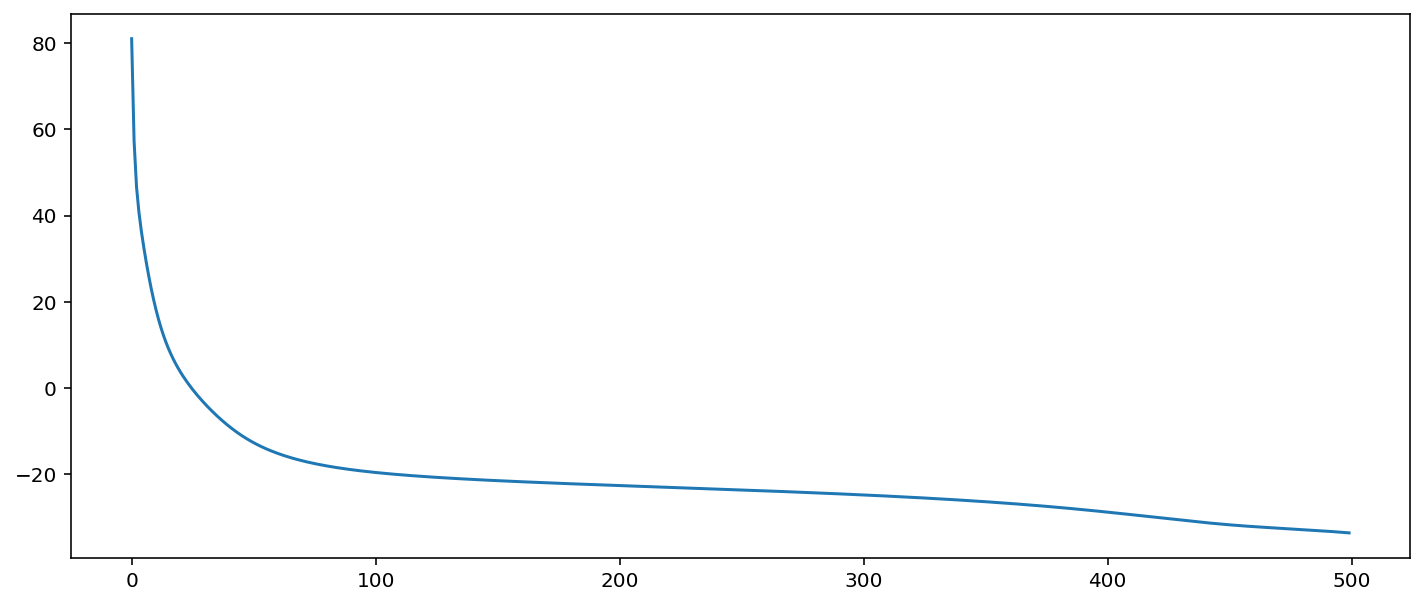

In [36]:
plt.figure(figsize=(12, 5))
plt.plot(E_hist)

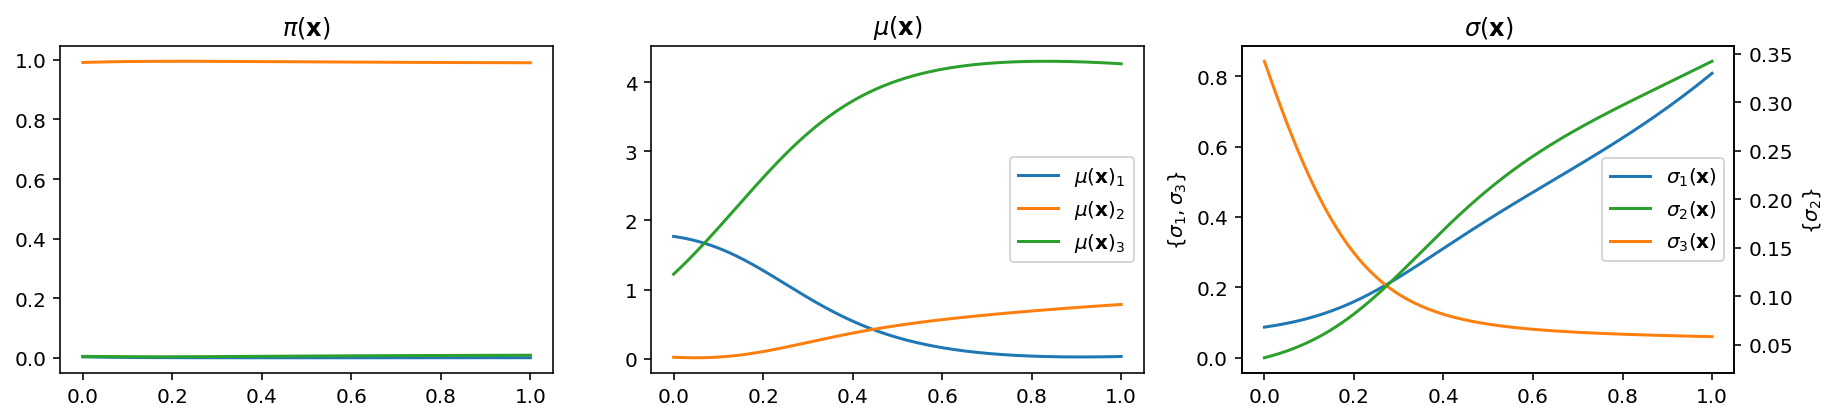

In [32]:
xrange = np.linspace(0, 1, 300)
pi, mu, sigma = mixture_coefs(w0, xrange[:, np.newaxis])

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
ax[0].plot(xrange, pi);

m1, m2, m3 = ax[1].plot(xrange, mu)
ax[1].legend([m1, m2, m3],
           [r"$\mu({\bf x})_{k}$".replace("k", str(i)) for i in range(1, 4)]);

ax2 = ax[2].twinx()
ax[2].plot(xrange,sigma[:,0], label=r"$\sigma_1({\bf x})$")
ax[2].plot(0, 0, label=r"$\sigma_2({\bf x})$", color="tab:green")
ax[2].plot(xrange,sigma[:,2], label=r"$\sigma_3({\bf x})$")
ax[2].legend()
ax2.plot(xrange, sigma[:, 1], color="tab:green")
ax[2].set_ylabel(r"$\{\sigma_1, \sigma_3\}$")
ax2.set_ylabel(r"$\{\sigma_2\}$");

titles = [r"$\pi({\bf x})$", r"$\mu({\bf x})$", r"$\sigma({\bf x})$"]
for axi, title in zip(ax, titles):
    axi.set_title(title)

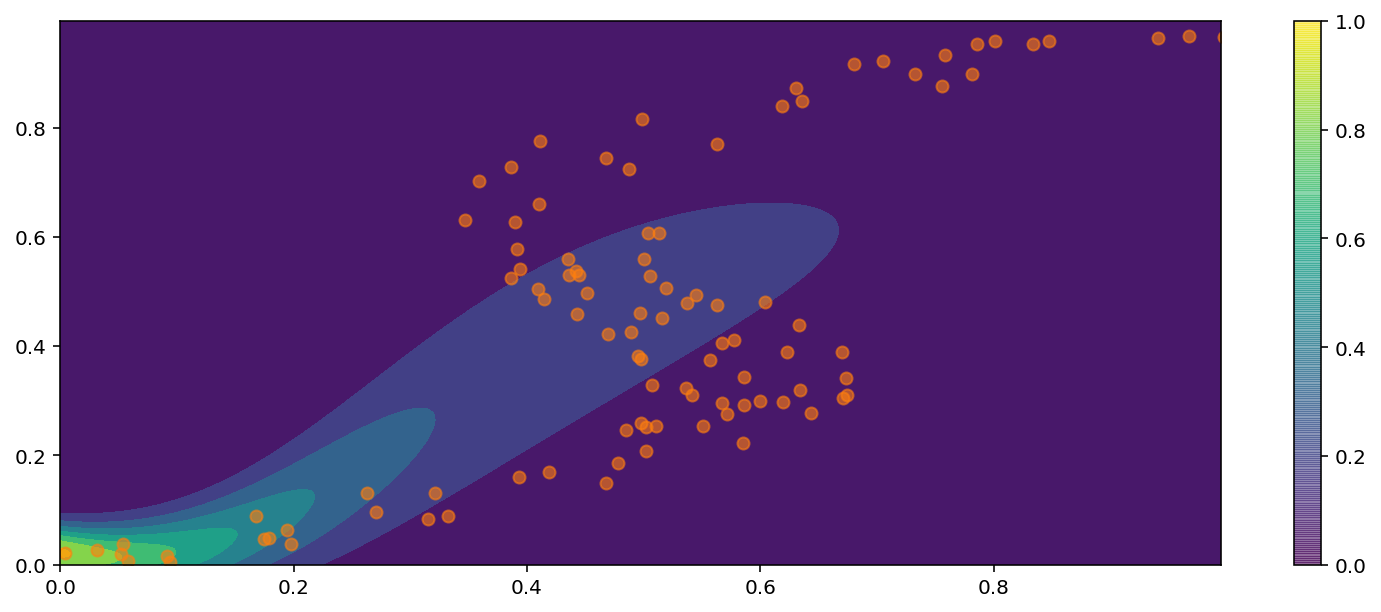

In [33]:
grid = np.mgrid[0:1:0.005, 0:1:0.005]
values = grid.T.reshape(-1, 2)
x = values[:, [0]]
t = values[:, 1]

mixture_gaussian = mdn(w0, x, t)

sx, sy = grid.shape[1:]
mixture_map = mixture_gaussian.reshape(sy, sx).T

plt.figure(figsize=(13, 5))
plt.contourf(*grid, mixture_map)
xlim, ylim = plt.xlim(), plt.ylim()
plt.scatter(tn, xn, c="tab:orange", alpha=0.6)
plt.xlim(xlim)
plt.ylim(ylim)
plt.colorbar()

In [34]:
from ipywidgets import interact, FloatSlider

xrange = np.linspace(0, 1, 300)
@interact(t=FloatSlider(min=0, max=1, step=0.1, value=0.5))
def plot_mdn(t):
    dist = mdn(w0, np.array([[t]]), xrange)
    plt.plot(xrange, dist)
    plt.title(f"p(t={t}|x)")
    plt.xlabel("$x$")

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0), Output()), _dom_classes=('widget-inter…

### Training the MDN with L-BFGS

In [ ]:
nnw = minimize(E, w, (tn[:, np.newaxis], xn), method="l-bfgs-b",
               tol=1e-10)
nnw